# 3. Basic model from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [1]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [2]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
tensorflow 2.7.0 TensorFlow is an open source machine learning framework for everyone.
├── absl-py >=0.4.0
│   └── six * 
├── astunparse >=1.6.0
│   └── six >=1.6.1,<2.0 
├── flatbuffers >=1.12,<3.0
├── gast >=0.2.1,<0.5.0
├── google-pasta >=0.1.1
│   └── six * 
├── grpcio >=1.24.3,<2.0
│

If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [4]:
nb_datapoints = 10
input_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

Suppose that we want to approximate the 'true' function \bar{f}(x) = x/2 + 1:


In [5]:
output_dim = 1

weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [6]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}')

x: (10, 1), weights: (1, 1), bias: (1,), y_true: (10, 1)


Let's plot our true function:

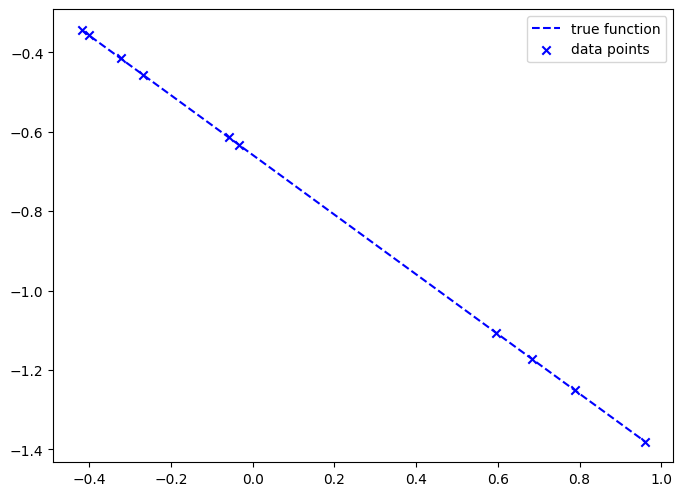

In [7]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b--', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.legend()
plt.show()

### Linear model

Let us define the simplest model: one layer, linear, no activation function. This is equivalent to linear regression.

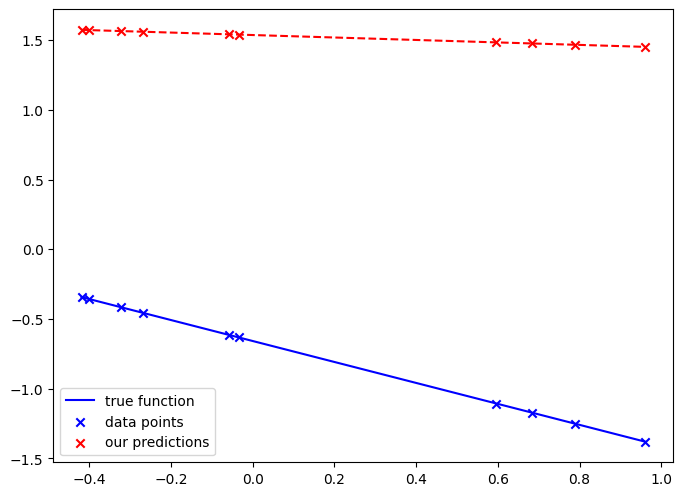

In [8]:
class LinearLayer:
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim) # Not sure why FSDL had np.sqrt(2. / input_dim)
    # It is best to think of the weights as a matrix acting on the input (given as a line vector) by multiplication *on the right*
    self.bias = np.random.randn(output_dim) * np.sqrt(1. / input_dim) # FSDL initializes them to zero: np.zeros(output_dim)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  # Mind that the first dim of x corresponds to the number of data points.
  # In numpy, when doing matrix multiplication, if either argument is N-dimensional, N > 2, 
  # then it is treated as a stack of matrices residing in the last two indexes.

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    x = self.x # x has shape (nb_datapoints, input_dim) 
    # previous_grad has shape (nb_datapoints, output_dim)
    self.weights_gradient = x.T @ previous_grad # shape (input_dim, output_dim)
    self.bias_gradient = previous_grad.sum(axis=0) # shape (output_dim,)
    self.x_gradient = previous_grad @ self.weights.T # shape (nb_datapoints, input_dim)
    return self.x_gradient

  def update(self, learning_rate):
    self.weights = self.weights - learning_rate*self.weights_gradient
    self.bias = self.bias - learning_rate*self.bias_gradient
    

linear = LinearLayer(1, 1)
y_pred = linear(x)
figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b-', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
plt.scatter(x.squeeze(-1), y_pred.squeeze(-1), color='r', marker='x', label='our predictions')
plt.legend()
plt.show()

Basic metric: MSE


In [9]:
class MSE:
  def __call__(self, y, y_true):
    # y and y true have shape (nb_datapoints, output_dim)
    return ((y - y_true) ** 2).sum(axis=1).mean(axis=0)

  def gradient(self, y, y_true):
    nb_datapoints = y.shape[0]
    return 2. * (y - y_true) / nb_datapoints # shape (nb_datapoints, output_dim)
    # Note: We divide by |nb_datapoints| to not have to do it during backpropagation

  
metric = MSE()
print(f'Our initial loss is {metric(y_pred, y_true)}')

Our initial loss is 5.387438954730869


Let's now create our model:

In [10]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(self.x)

    def loss(self, x, y_true):
        return self.metric(self(x), y_true)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

Let's try it! Observe that the loss decreases after one forward and backward pass.

In [11]:

def fbar(x):
  return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (10, 1))
y_true = fbar(x)


linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)

print(f"loss = {model.loss(x, y_true)}")

model.forward(x)
model.backward(y_true, 0.1)
print(f"loss = {model.loss(x, y_true)}")

loss = 7.114582524417971
loss = 4.810191113976824


Let's add some bells and whistles:

In [12]:
# We'll use this to shuffle the dataset (and labels accordingly)
def shuffle_sync(*arrs):
    '''Shuffles arrays of the same length according to a same random permutation'''
    seed = np.random.randint(0, 2**(32 - 1) - 1)
    for arr in arrs:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

x = np.arange(10)
y = np.arange(10, 20)
print(x,y)
shuffle_sync(x,y)
print(x,y)

[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
[7 5 3 6 8 2 0 1 9 4] [17 15 13 16 18 12 10 11 19 14]


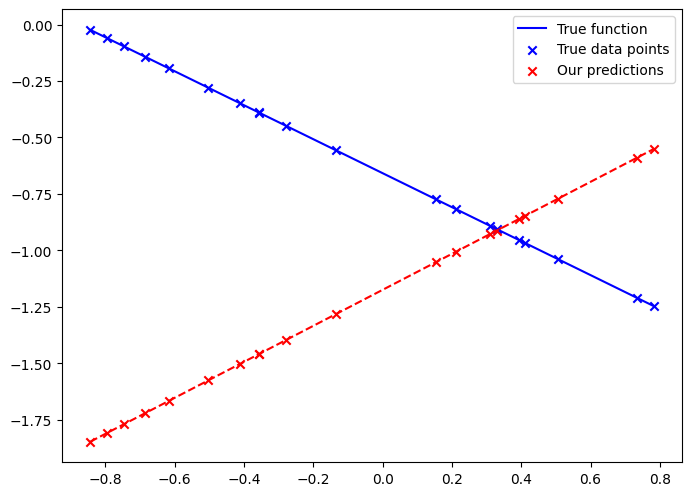

Epoch 1: loss = 0.04113424416951146
Epoch 2: loss = 0.0005931291262041798
Epoch 3: loss = 4.468766182684212e-05
Epoch 4: loss = 5.54758759261024e-06
Epoch 5: loss = 3.483277025639123e-07
Epoch 6: loss = 2.044751453088085e-08
Epoch 7: loss = 1.5860890045644663e-09
Epoch 8: loss = 1.4520618877352193e-10
Epoch 9: loss = 4.998754406645276e-12
Epoch 10: loss = 3.5733244153886923e-13


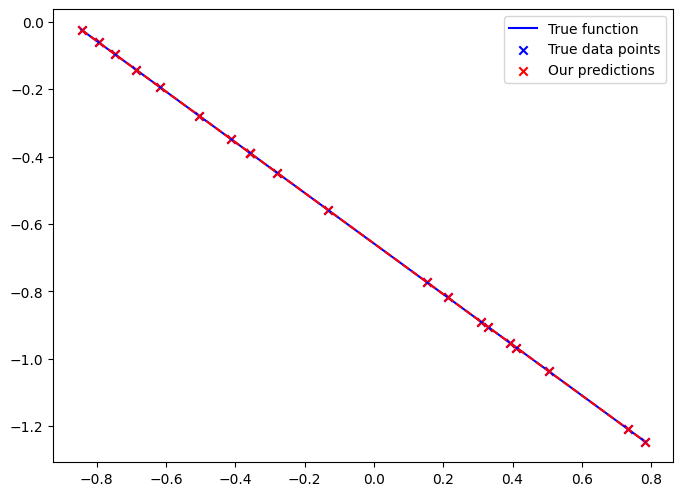

In [13]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(x)

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        plot3d_sim(x=self.x_training, y_pred = model(self.x_training), y_true = self.y_true_training)

def plot3d_sim(x, y_true, y_pred):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
    plt.legend()
    plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(10)
model.plot()

Let's try to approximate a non-linear function:

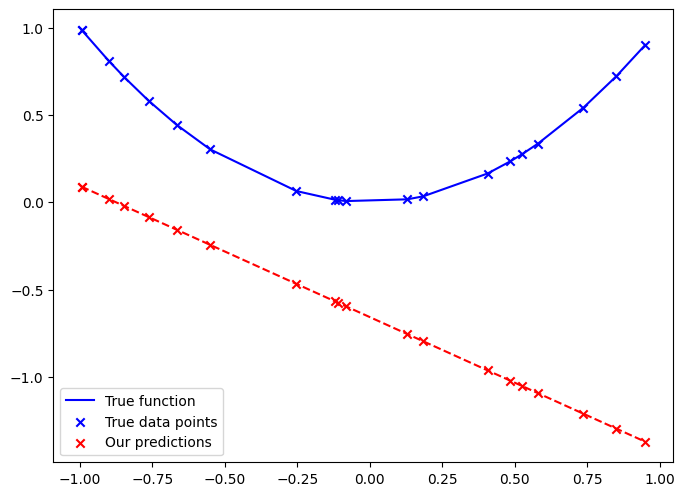

Epoch 1: loss = 0.3844326896936615
Epoch 2: loss = 0.17925277374423482
Epoch 3: loss = 0.1390795496500767
Epoch 4: loss = 0.12223740607779092
Epoch 5: loss = 0.11453939667004291
Epoch 6: loss = 0.11030528668165263
Epoch 7: loss = 0.10834163175750175
Epoch 8: loss = 0.1074263762805415
Epoch 9: loss = 0.10780444091315156
Epoch 10: loss = 0.10682136759737929
Epoch 11: loss = 0.10665877352096145
Epoch 12: loss = 0.10676986884879369
Epoch 13: loss = 0.10667851365844579
Epoch 14: loss = 0.1067271394761973
Epoch 15: loss = 0.10662619272897067
Epoch 16: loss = 0.1066116814100897
Epoch 17: loss = 0.10675692807063153
Epoch 18: loss = 0.10662275388260564
Epoch 19: loss = 0.10660631265769327
Epoch 20: loss = 0.10672176088873557


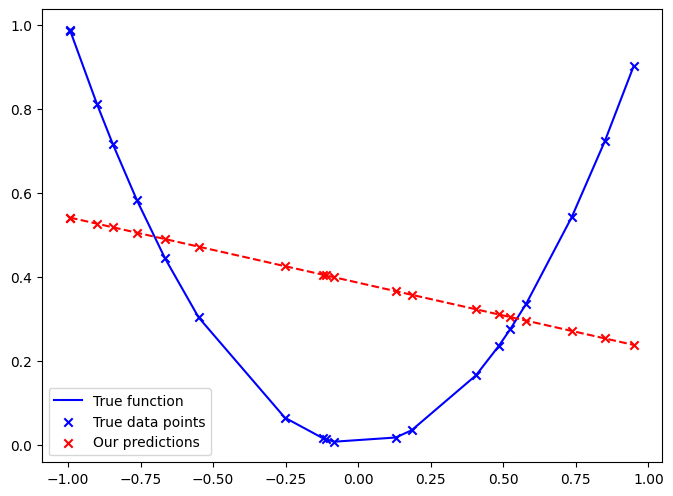

In [14]:
def fbar(x):
    return x ** 2

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

### 2-dimensional inputs work too

(100, 2)
(2, 1)


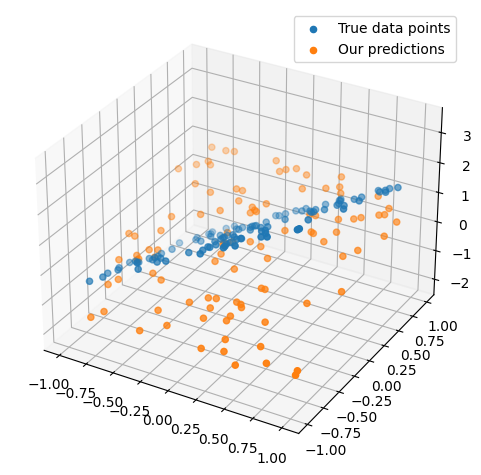

Epoch 1: loss = 7.655642215329974e-09
Epoch 2: loss = 1.725279643650168e-17
Epoch 3: loss = 1.3541392165285495e-28


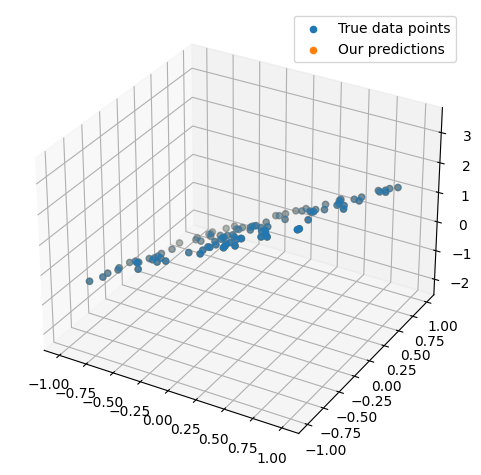

In [15]:
nb_datapoints = 100
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])

print(x.shape)
print(weights_true.shape)

def fbar(x):
  return x @ weights_true + bias_true

y_true = fbar(x)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)

model.plot3d()
model.train(3)
model.plot3d()

(1000, 1)


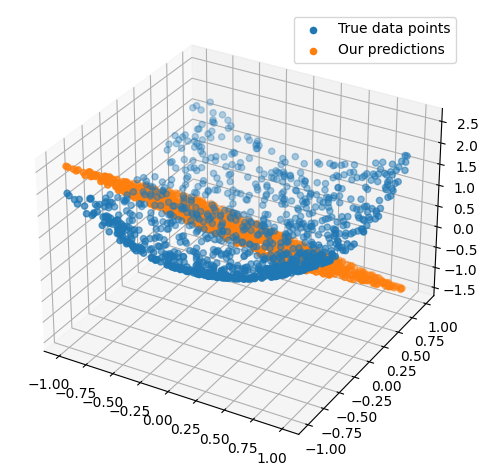

Epoch 1: loss = 0.18235981967206438
Epoch 2: loss = 0.37991297139622776
Epoch 3: loss = 0.2277301982703192
Epoch 4: loss = 0.24979365991597346
Epoch 5: loss = 0.18586312701795998
Epoch 6: loss = 0.2522226845257747
Epoch 7: loss = 0.20671501385168284
Epoch 8: loss = 0.4227889442754991
Epoch 9: loss = 0.36627801310757
Epoch 10: loss = 0.24549932855281822


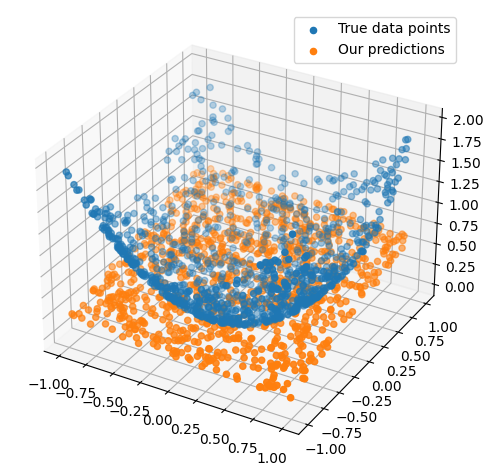

In [16]:
def fbar(x):
  return (x**2).sum(axis=1)[..., None]

nb_datapoints = 1000
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

y_true = fbar(x)
print(y_true.shape)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot3d()
model.train(10)
model.plot3d()

### Add non-linearity: ReLU

In [17]:
class ReluLayer:  
  def __call__(self, x):
    return np.clip(x, 0, None)

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    self.gradient = (self.x > 0) * previous_grad
    return self.gradient

  def update(self, learning_rate):
    return




f = ReluLayer()
x1 = np.random.uniform(-1, 1, (3, 2))
print(x1)
print(f(x1))

[[-0.49645526  0.39307477]
 [ 0.36492889  0.281827  ]
 [-0.07578523  0.94270798]]
[[0.         0.39307477]
 [0.36492889 0.281827  ]
 [0.         0.94270798]]


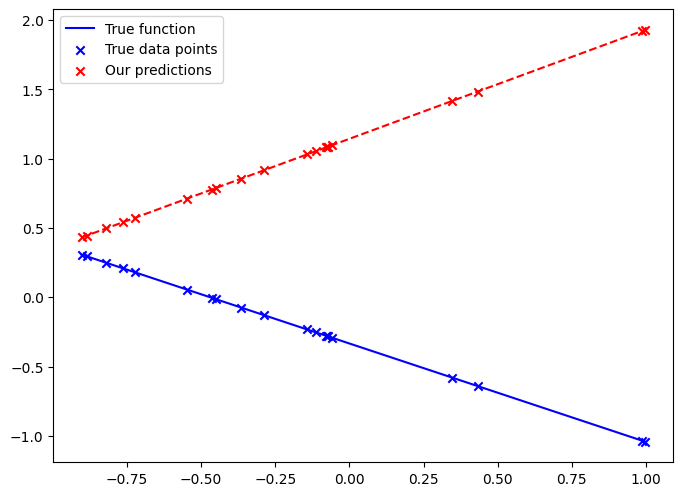

Epoch 1: loss = 0.7268444910078093
Epoch 2: loss = 0.33007175229927566
Epoch 3: loss = 0.21967008610459512
Epoch 4: loss = 0.18453831236404367
Epoch 5: loss = 0.18453831236404367
Epoch 6: loss = 0.18453831236404367
Epoch 7: loss = 0.18453831236404367
Epoch 8: loss = 0.18453831236404367
Epoch 9: loss = 0.18453831236404367
Epoch 10: loss = 0.18453831236404367
Epoch 11: loss = 0.18453831236404367
Epoch 12: loss = 0.18453831236404367
Epoch 13: loss = 0.18453831236404367
Epoch 14: loss = 0.18453831236404367
Epoch 15: loss = 0.18453831236404367
Epoch 16: loss = 0.18453831236404367
Epoch 17: loss = 0.18453831236404367
Epoch 18: loss = 0.18453831236404367
Epoch 19: loss = 0.18453831236404367
Epoch 20: loss = 0.18453831236404367


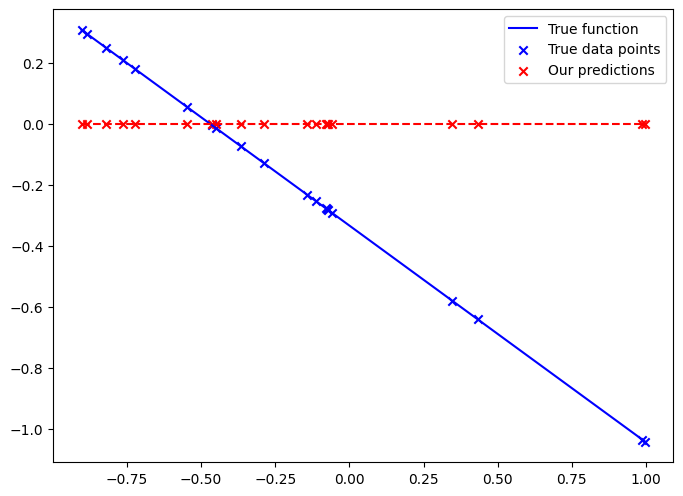

In [18]:
class Model:
    def __init__(self, *layers, metric):
        self.layers = layers
        self.metric = metric

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        for layer in self.layers:
            y = layer.forward(x)
            x = y
        self.y = y
        return y

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true)
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
            layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        plot3d_sim(x = self.x_training, y_pred = model(self.x_training), y_true = self.y_true_training)


nb_datapoints = 20
input_dim = 1
output_dim = 1
weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

lin = LinearLayer(1, 1)
rel = ReluLayer()
met = MSE()
model = Model(lin, rel, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

Oops! Of course our model cannot produce negative predictions. Like add a second linear layer:

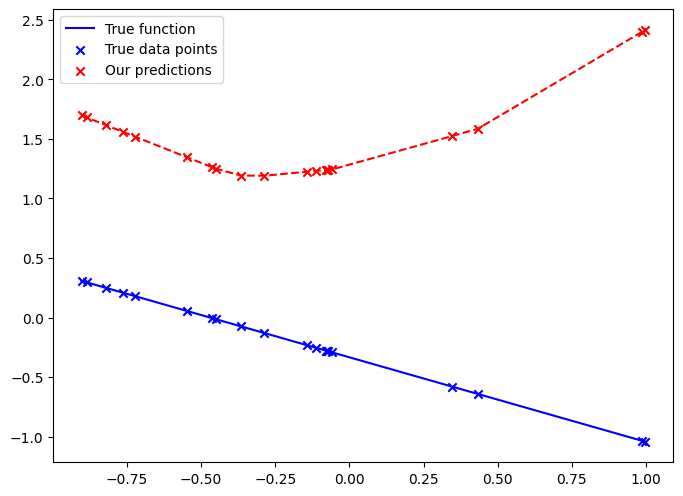

Epoch 1: loss = 0.09477488057413011
Epoch 2: loss = 0.04308275358971839
Epoch 3: loss = 0.04320945988210828
Epoch 4: loss = 0.045547858482564096
Epoch 5: loss = 0.016607624599089498
Epoch 6: loss = 0.012083684189247611
Epoch 7: loss = 0.015956121604145553
Epoch 8: loss = 0.0074635581758783
Epoch 9: loss = 0.00562951483985096
Epoch 10: loss = 0.004384053492100589
Epoch 11: loss = 0.004497466295186307
Epoch 12: loss = 0.003430279546652906
Epoch 13: loss = 0.0038472289233902656
Epoch 14: loss = 0.002914824161295527
Epoch 15: loss = 0.0016782643973292245
Epoch 16: loss = 0.001512903959495087
Epoch 17: loss = 0.002084770429118739
Epoch 18: loss = 0.00203460815620713
Epoch 19: loss = 0.0014524546080548085
Epoch 20: loss = 0.0013297494313939161
Epoch 21: loss = 0.0015802367680245785
Epoch 22: loss = 0.0013680667462337142
Epoch 23: loss = 0.0008369049443789555
Epoch 24: loss = 0.0021194476457120663
Epoch 25: loss = 0.0007511413510400319
Epoch 26: loss = 0.0007910445767668051
Epoch 27: loss = 0

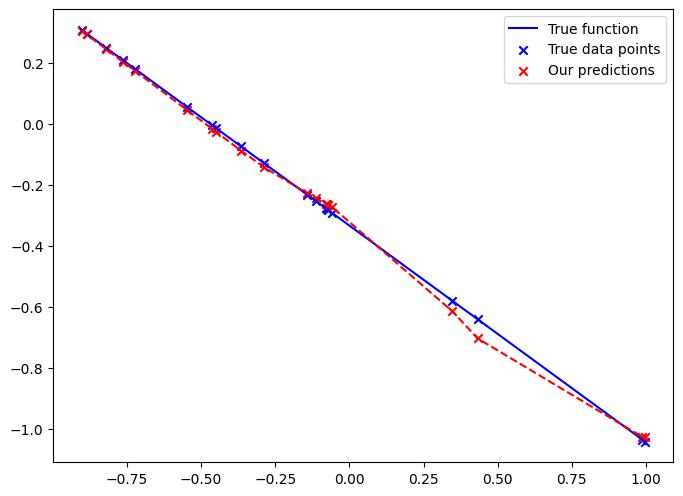

In [19]:
lin1 = LinearLayer(1, 10)
rel1 = ReluLayer()
lin2 = LinearLayer(10, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(50)
model.plot()

What about approximating a non-linear function?

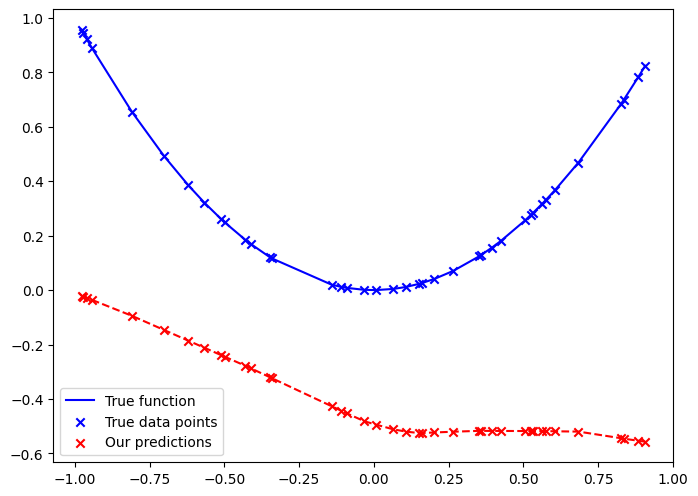

Epoch 1: loss = 0.055862521281467
Epoch 2: loss = 0.04209760377534368
Epoch 3: loss = 0.047190773902499664
Epoch 4: loss = 0.02011863281101419
Epoch 5: loss = 0.018605147909420645
Epoch 6: loss = 0.014405506722128727
Epoch 7: loss = 0.00876583692371443
Epoch 8: loss = 0.010499136333194103
Epoch 9: loss = 0.00868498133176487
Epoch 10: loss = 0.0064628284804820356
Epoch 11: loss = 0.0057696725994366115
Epoch 12: loss = 0.011287825303112644
Epoch 13: loss = 0.011690354036432227
Epoch 14: loss = 0.009752794813681442
Epoch 15: loss = 0.0045461809388847585
Epoch 16: loss = 0.0044265705926721756
Epoch 17: loss = 0.005090625784294969
Epoch 18: loss = 0.005389355695301781
Epoch 19: loss = 0.004463835210011728
Epoch 20: loss = 0.008657976911026658
Epoch 21: loss = 0.004775785859353383
Epoch 22: loss = 0.004140384358527467
Epoch 23: loss = 0.004664992251404061
Epoch 24: loss = 0.004305586746365117
Epoch 25: loss = 0.005778619949929929
Epoch 26: loss = 0.00464736285591098
Epoch 27: loss = 0.003652

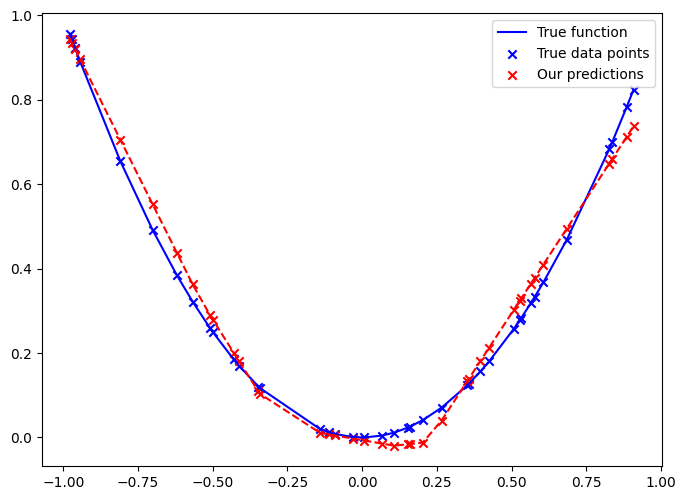

In [20]:
nb_datapoints = 40
input_dim = 1
output_dim = 1

def fbar(x):
    return x**2

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

nb_hidden = 20
lin1 = LinearLayer(1, nb_hidden)
rel1 = ReluLayer()
lin2 = LinearLayer(nb_hidden, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(100)
model.plot()

Notice how it's very sensitive to the hyperparameters! For instance, a learning rate >0.2 won't work.

What about 2D?

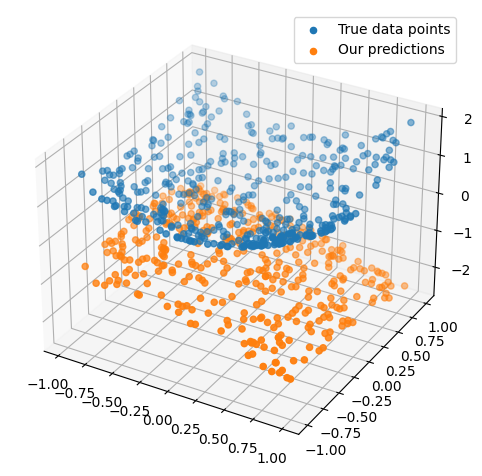

Epoch 1: loss = 0.04735979486734637
Epoch 2: loss = 0.008698616503989107
Epoch 3: loss = 0.005966097422455975
Epoch 4: loss = 0.013543653003226287
Epoch 5: loss = 0.005677166939550615
Epoch 6: loss = 0.006063428120079329
Epoch 7: loss = 0.011601682524630381
Epoch 8: loss = 0.005047643246763468
Epoch 9: loss = 0.0059458237950763635
Epoch 10: loss = 0.005715050181592958
Epoch 11: loss = 0.003863765696298994
Epoch 12: loss = 0.0048727803269678835
Epoch 13: loss = 0.005919160022295744
Epoch 14: loss = 0.003915446601626447
Epoch 15: loss = 0.004791313531984617
Epoch 16: loss = 0.003807901965622955
Epoch 17: loss = 0.0038353821267717793
Epoch 18: loss = 0.004027822637881976
Epoch 19: loss = 0.0033796798492543214
Epoch 20: loss = 0.004893121950263621
Epoch 21: loss = 0.0036824236990764918
Epoch 22: loss = 0.0037815827620674637
Epoch 23: loss = 0.0031755002926385912
Epoch 24: loss = 0.003802051528063768
Epoch 25: loss = 0.0031259803698116912
Epoch 26: loss = 0.0030858181584140047
Epoch 27: los

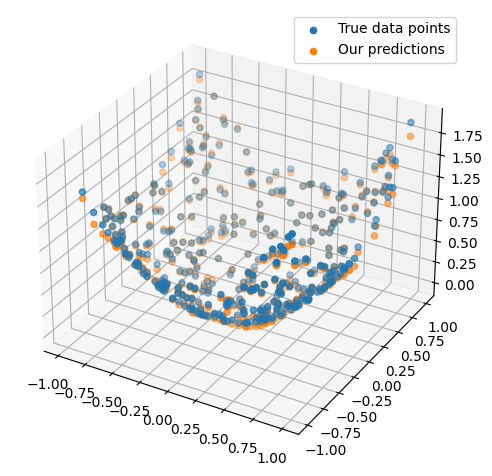

In [21]:
nb_datapoints = 400
input_dim = 2
output_dim = 1

def fbar(x):
    return (x**2).sum(axis=1)[..., None]

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))



nb_hidden = 20
lin1 = LinearLayer(input_dim, nb_hidden)
rel1 = ReluLayer()
lin2 = LinearLayer(nb_hidden, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot3d()
model.train(100)
model.plot3d()

### Same thing, in PyTorch

In [22]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, nb_hidden):
    super().__init__()
    self.lin1 = nn.Linear(input_dim, nb_hidden)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(nb_hidden, 1)
  
  def forward(self, x):
    x = self.lin1(x)
    x = self.relu(x)
    x = self.lin2(x)
    return x

input_dim = 2
nb_datapoints = 400
nb_hidden = 20

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
y_true = (x**2).sum(axis=1)[..., None]

loss = nn.MSELoss()
model = TorchModel(input_dim, nb_hidden)

x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(1.0715, grad_fn=<MseLossBackward0>)


In [23]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(1.0715, grad_fn=<MseLossBackward0>)
tensor(0.2930, grad_fn=<MseLossBackward0>)


tensor(0.2930, grad_fn=<MseLossBackward0>)
tensor(0.1773, grad_fn=<MseLossBackward0>)
tensor(0.1541, grad_fn=<MseLossBackward0>)
tensor(0.1458, grad_fn=<MseLossBackward0>)
tensor(0.1406, grad_fn=<MseLossBackward0>)
tensor(0.1366, grad_fn=<MseLossBackward0>)
tensor(0.1333, grad_fn=<MseLossBackward0>)
tensor(0.1305, grad_fn=<MseLossBackward0>)
tensor(0.1282, grad_fn=<MseLossBackward0>)
tensor(0.1261, grad_fn=<MseLossBackward0>)
tensor(0.1243, grad_fn=<MseLossBackward0>)
tensor(0.1227, grad_fn=<MseLossBackward0>)
tensor(0.1212, grad_fn=<MseLossBackward0>)
tensor(0.1198, grad_fn=<MseLossBackward0>)
tensor(0.1185, grad_fn=<MseLossBackward0>)
tensor(0.1173, grad_fn=<MseLossBackward0>)
tensor(0.1161, grad_fn=<MseLossBackward0>)
tensor(0.1150, grad_fn=<MseLossBackward0>)
tensor(0.1139, grad_fn=<MseLossBackward0>)
tensor(0.1129, grad_fn=<MseLossBackward0>)
tensor(0.1118, grad_fn=<MseLossBackward0>)
tensor(0.1108, grad_fn=<MseLossBackward0>)
tensor(0.1098, grad_fn=<MseLossBackward0>)
tensor(0.10

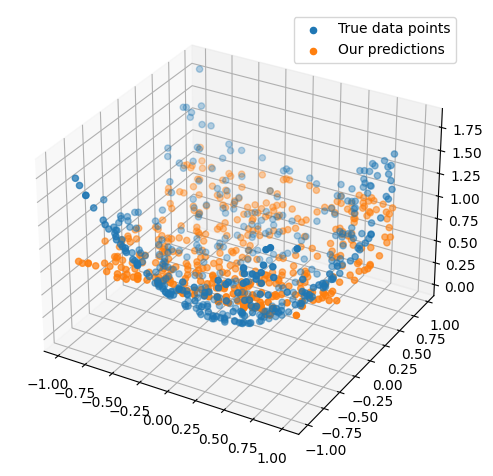

In [24]:
from typing import Callable


# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=50)

plot3d_sim(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

2022-02-01 17:03:19.774686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 17:03:19.774715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-01 17:03:21.785307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 17:03:21.786268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 17:03:21.786339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
 regression (Dense)          (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
13/13 [==============================] - 1s 1ms/step - loss: 0.1802
Epoch 2/10
13/13 [==============================] - 0s 1ms/step - loss: 0.1028
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0910
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 5/

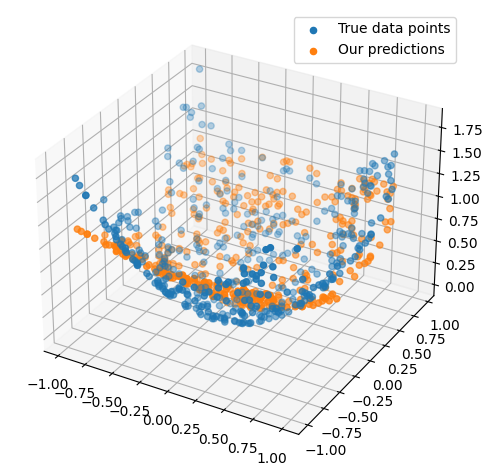

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)



plot3d_sim(x, y_true, model(x))